# Setup

In [1]:
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
matplotlib.rcdefaults()
matplotlib.rcParams['text.usetex'] = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Useful functions for two-layer nets

def pred(X, W, a, phi):
    return phi(X @ W.T) @ a

def grad(X, y, W, a, phi, phiprime):
    n = X.shape[0]
    V_1 = 1 / np.sqrt(n) * phiprime(W @ X.T) * a.reshape(-1, 1)
    V_2 = 1 / np.sqrt(n) * X * (pred(X, W, a, phi) - y).reshape(-1, 1)
    return V_1 @ V_2

def relu(z):
    return torch.maximum(z, torch.zeros_like(z))

def reluprime(z):
    return 1.0 * (z >= 0)

def He2(z):
    return (z**2 - 1) / np.sqrt(2)

def optimize(X, y, W0, a, phi, phiprime, n_iters=100, lr=0.1, inv_temp=0.001, weight_decay=0.01, verbose=False):
    W = W0.clone()
    m = W.shape[0]
    losses = []
    for i in range(n_iters):
        W = W - lr * m * grad(X, y, W, a, phi, phiprime) - lr * weight_decay * W \
                        + 2 * np.sqrt(lr * inv_temp) * torch.randn_like(W)
        losses.append(torch.mean((pred(X, W, a, phi) - y) ** 2).item())
        if verbose and i % (n_iters // 20) == 0:
            print(losses[-1])
    return W, losses

## Training Dynamics Sanity Check

In [4]:
n, m, d = 2000, 50, 50

m_true = 1
w_true = torch.zeros(d).to(device)
w_true[0] = 1.
a_true = torch.ones(m_true).to(device) / np.sqrt(m_true)

X = torch.randn(n, d).to(device)
y = He2(X @ w_true)

W = torch.randn(m, d).to(device)
W /= torch.linalg.norm(W, dim=1).unsqueeze(1)
a = torch.concatenate((torch.ones(m // 2), -torch.ones(m // 2))).to(device) / m

In [5]:
W_new, losses = optimize(X, y, W, a, relu, reluprime, n_iters=3000, inv_temp=0.001)

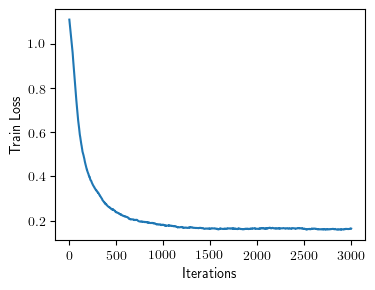

In [6]:
fig, ax = plt.subplots(figsize=(4,3))
ax.set_ylabel('Train Loss')
ax.set_xlabel('Iterations')
ax.plot(losses)
plt.show()

# Gen Gap vs Effective Dimension

In [7]:
def measure_gen_gap(deff, n=100, m=50, d=50):
    torch.manual_seed(42)
    w_true = torch.zeros(d).to(device)
    w_true[0] = 1.
    
    sigmas = torch.ones(d).to(device)
    sigmas[1:] *= np.sqrt((deff - 1) / (d - 1))
    Sigma_hf = torch.diag(sigmas)
    
    X = torch.randn(n, d).to(device) @ Sigma_hf
    X_bias = torch.hstack((X, torch.ones(n, 1).to(device)))
    y = He2(X @ w_true)
                          
    W = torch.randn(m, d + 1).to(device)
    W /= torch.linalg.norm(W, dim=1).unsqueeze(1)
    a = torch.concatenate((torch.ones(m // 2), -torch.ones(m // 2))).to(device) / m                      
    
    W_new, losses = optimize(X_bias, y, W, a, relu, reluprime, n_iters=3000, inv_temp=0.001, weight_decay=0.01)
    
    X_test = torch.randn(100000, d).to(device) @ Sigma_hf
    X_test_bias = torch.hstack((X_test, torch.ones(100000, 1).to(device)))
    y_test = He2(X_test @ w_true)
    
    test_loss = torch.mean((pred(X_test_bias, W_new, a, relu) - y_test) ** 2).item()
    return test_loss - losses[-1]

In [8]:
gaps_100 = []
for deff in tqdm(range(1, 51)):
    gaps_100.append(measure_gen_gap(deff))
    if deff % 10 == 0:
        print(f'deff: {deff}, Gen gap: {gaps_100[-1]}')

  0%|          | 0/50 [00:00<?, ?it/s]

deff: 10, Gen gap: 0.33237089961767197
deff: 20, Gen gap: 0.5841763690114021
deff: 30, Gen gap: 0.8098943959921598
deff: 40, Gen gap: 1.0495691504329443
deff: 50, Gen gap: 1.2345942612737417


In [9]:
gaps_200 = []
for deff in tqdm(range(1, 51)):
    gaps_200.append(measure_gen_gap(deff, n=200))
    if deff % 10 == 0:
        print(f'deff: {deff}, Gen gap: {gaps_200[-1]}')

  0%|          | 0/50 [00:00<?, ?it/s]

deff: 10, Gen gap: 0.16651764512062073
deff: 20, Gen gap: 0.2801348865032196
deff: 30, Gen gap: 0.41297647356987
deff: 40, Gen gap: 0.5178140066564083
deff: 50, Gen gap: 0.6747847124934196


In [10]:
gaps_500 = []
for deff in tqdm(range(1, 51)):
    gaps_500.append(measure_gen_gap(deff, n=500))
    if deff % 10 == 0:
        print(f'deff: {deff}, Gen gap: {gaps_500[-1]}')

  0%|          | 0/50 [00:00<?, ?it/s]

deff: 10, Gen gap: 0.039887934923172
deff: 20, Gen gap: 0.07241082936525345
deff: 30, Gen gap: 0.10308519005775452
deff: 40, Gen gap: 0.12617649137973785
deff: 50, Gen gap: 0.15650716423988342


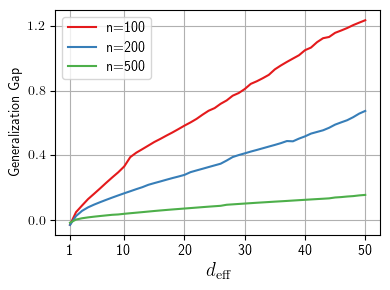

In [12]:
fig, ax = plt.subplots(figsize=(4, 3))

ax.plot(range(1, 51), gaps_100, color='#e41a1c', label='n=100')
ax.plot(range(1, 51), gaps_200, color='#377eb8', label='n=200')
ax.plot(range(1, 51), gaps_500, color='#4daf4a', label='n=500')
ax.set_xlabel(r'$d_{\mathrm{eff}}$', fontsize=14)
ax.set_ylabel('Generalization Gap')

ax.set_xticks([1, 10, 20, 30, 40, 50])
ax.set_xticklabels([1, 10, 20, 30, 40, 50])
ax.set_yticks([0.0, 0.4, 0.8, 1.2])
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.savefig('gen_gap.pdf')

# Sample Complexity vs Effective Dimension

In [ ]:
m, d = 50, 50
torch.manual_seed(42)

w_true = torch.zeros(d).to(device)
w_true[0] = 1.

W0 = torch.randn(m, d + 1).to(device)
W0 /= torch.linalg.norm(W0, dim=1).unsqueeze(1)
a = torch.concatenate((torch.ones(m // 2), -torch.ones(m // 2))).to(device) / m   

Trials = 5

deffs = np.arange(5, 51, 3, dtype=int)
ns = np.arange(50, 501, 30, dtype=int)
all_losses = torch.zeros((Trials, len(deffs), len(ns)))

for trial in range(Trials):
    print(f'Trial: {trial}')
    for i, deff in tqdm(enumerate(deffs), total=len(deffs)):
        sigmas = torch.ones(d).to(device)
        sigmas[1:] *= np.sqrt((deff - 1) / (d - 1))
        Sigma_hf = torch.diag(sigmas)

        X_test = torch.randn(100000, d).to(device) @ Sigma_hf
        X_test_bias = torch.hstack((X_test, torch.ones(100000, 1).to(device)))
        y_test = He2(X_test @ w_true)

        X_train = torch.randn(ns[-1], d).to(device) @ Sigma_hf
        X_train_bias = torch.hstack((X_train, torch.ones(ns[-1], 1).to(device)))
        y_train = He2(X_train @ w_true)
        losses = []


        for j, n in enumerate(ns):
            X_bias = X_train_bias[:n]
            y = y_train[:n]

            W, train_losses = optimize(X_bias, y, W0, a, relu, reluprime, n_iters=200, inv_temp=0.001, weight_decay=0.01)
            test_loss = torch.mean((pred(X_test_bias, W, a, relu) - y_test) ** 2)
            if (i * len(ns) + j) % (len(deffs) * len(ns) // 5) == 0:
                print(f'n: {n}, deff: {deff}, test loss: {test_loss}')
            all_losses[trial, i, j] = test_loss
    print()

Trial: 0


  0%|          | 0/16 [00:00<?, ?it/s]

n: 50, deff: 5, test loss: 0.5352259874343872
n: 140, deff: 14, test loss: 0.5656630992889404
n: 230, deff: 23, test loss: 0.7067763805389404
n: 320, deff: 32, test loss: 0.6203339695930481
n: 410, deff: 41, test loss: 0.6008959412574768
n: 500, deff: 50, test loss: 0.6235855221748352

Trial: 1


  0%|          | 0/16 [00:00<?, ?it/s]

n: 50, deff: 5, test loss: 0.4631683826446533
n: 140, deff: 14, test loss: 0.494720995426178
n: 230, deff: 23, test loss: 0.4556904137134552
n: 320, deff: 32, test loss: 0.5774851441383362
n: 410, deff: 41, test loss: 0.5209805965423584
n: 500, deff: 50, test loss: 0.5243473649024963

Trial: 2


  0%|          | 0/16 [00:00<?, ?it/s]

n: 50, deff: 5, test loss: 0.5798783302307129
n: 140, deff: 14, test loss: 0.5732761025428772


In [ ]:
mean_losses = all_losses.mean(dim=0)
mean_losses = mean_losses.flip(dims=(1,))

In [ ]:
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['ytick.labelsize'] = 18

plt.imshow(mean_losses.T, cmap='plasma_r', interpolation='nearest')
cbar = plt.colorbar(label='Test Loss', shrink=0.8)
cbar.set_label('Test Loss', fontsize=18)
cbar.set_ticks([0.5, 1.2])
plt.xlabel(r'$d_{\mathrm{eff}}$ (effective dimension)')
plt.ylabel(r'$n$ (sample complexity)')
plt.xticks([0, 7.5, 15], [deffs[0], 30, deffs[15]])
plt.yticks([0, 7.5, 15], [500, 300, 50])
plt.tight_layout()
plt.savefig('n_vs_deff.pdf')